## Trabalho de C209 L4
### Compressão JPEG

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

* Inserir a imagem

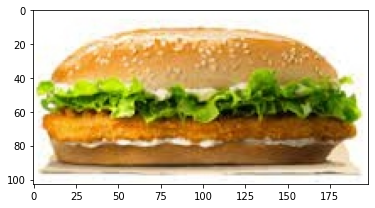

In [14]:
imageFile = 'image.jpg'
img = np.array(Image.open(imageFile))[:, :, :3]
plt.imshow(img)

* Captura as dimensões da imagem

In [15]:
height ,width = img.shape[:2]
print(f'Width: {width}, Height: {height}')

Width: 198, Height: 103


* Converter para escala de cinza

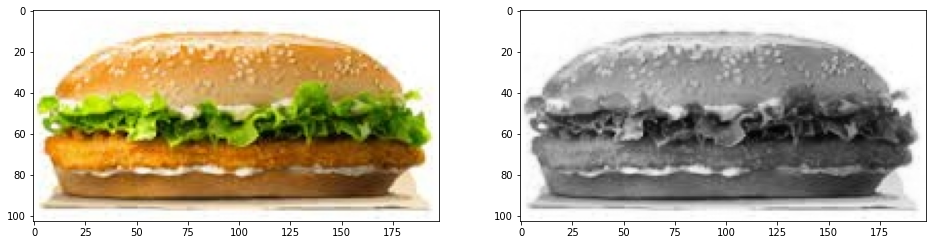

In [16]:
imgGray = np.zeros(shape=(height, width), dtype=np.uint8)
for i in range(height):
    for j in range(width):
        r = float(img[i, j, 0])
        g = float(img[i, j, 1])
        b = float(img[i, j, 2])
        
        imgGray[i, j] = (r + g + b) / 3

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(imgGray, cmap='gray')

* Divide a imagem em blocos de 8x8 pixels

In [17]:
block = 8
sliced = []

currY = 0
for i in range(block,height+1,block):
    currX = 0
    for j in range(block,width+1,block):
        sliced.append(imgGray[currY:i,currX:j]-np.ones((8,8))*128)
        currX = j
    currY = i
    
print(f'{len(sliced)} parts')

288 parts


In [18]:
imgSplit = [np.float32(imgGray) for imgGray in sliced]

* Aplica a Transformação Discreta do Cosseno

In [19]:
DCToutput = []
for part in imgSplit:
    currDCT = cv2.dct(part)
    DCToutput.append(currDCT)

* Etapa da Quantização, definindo o nivel de qualidade a ser comprimido

In [20]:
def selectQMatrix(qName):
    Q10 = np.array([[80,60,50,80,120,200,255,255],
                [55,60,70,95,130,255,255,255],
                [70,65,80,120,200,255,255,255],
                [70,85,110,145,255,255,255,255],
                [90,110,185,255,255,255,255,255],
                [120,175,255,255,255,255,255,255],
                [245,255,255,255,255,255,255,255],
                [255,255,255,255,255,255,255,255]])

    Q50 = np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,130,99]])

    Q90 = np.array([[3,2,2,3,5,8,10,12],
                    [2,2,3,4,5,12,12,11],
                    [3,3,3,5,8,11,14,11],
                    [3,3,4,6,10,17,16,12],
                    [4,4,7,11,14,22,21,15],
                    [5,7,11,13,16,12,23,18],
                    [10,13,16,17,21,24,24,21],
                    [14,18,19,20,22,20,20,20]])
    
    if qName == "Q10":
        return Q10
    elif qName == "Q50":
        return Q50
    elif qName == "Q90":
        return Q90
    else:
        return np.ones((8,8))

* Divisão DCT/Quantização -> arredonda para o numero inteiro mais proximo

In [21]:
selectedQMatrix = selectQMatrix("Q10")
for ndct in DCToutput:
    for i in range(block):
        for j in range(block):
            ndct[i,j] = np.around(ndct[i,j]/selectedQMatrix[i,j])

* Aplicar a inversa da DCT

In [22]:
invList = []
for ipart in DCToutput:
    curriDCT = cv2.idct(ipart)
    invList.append(curriDCT)

* Compila as informações para gerar a imagem

In [23]:
row = 0
rowNcol = []
for j in range(int(width/block),len(invList)+1,int(width/block)):
    rowNcol.append(np.hstack((invList[row:j])))
    row = j
res = np.vstack((rowNcol))

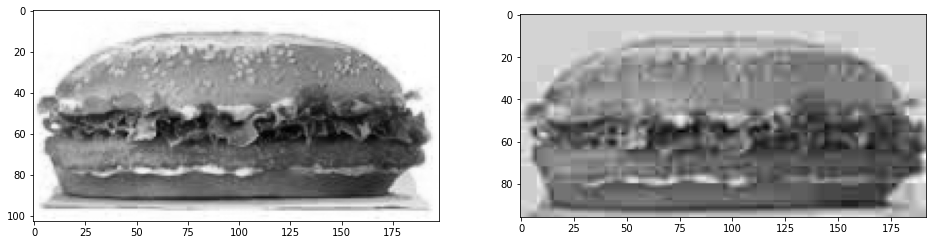

In [24]:
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(imgGray, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(res, cmap='gray')